# PD 6 Jan Smoleń

In [91]:
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
from skimage.io import imshow
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [92]:
ol=fetch_olivetti_faces()

In [93]:
X_og=ol.data.copy()
X=ol.data.copy()
imgs=ol.images.copy()

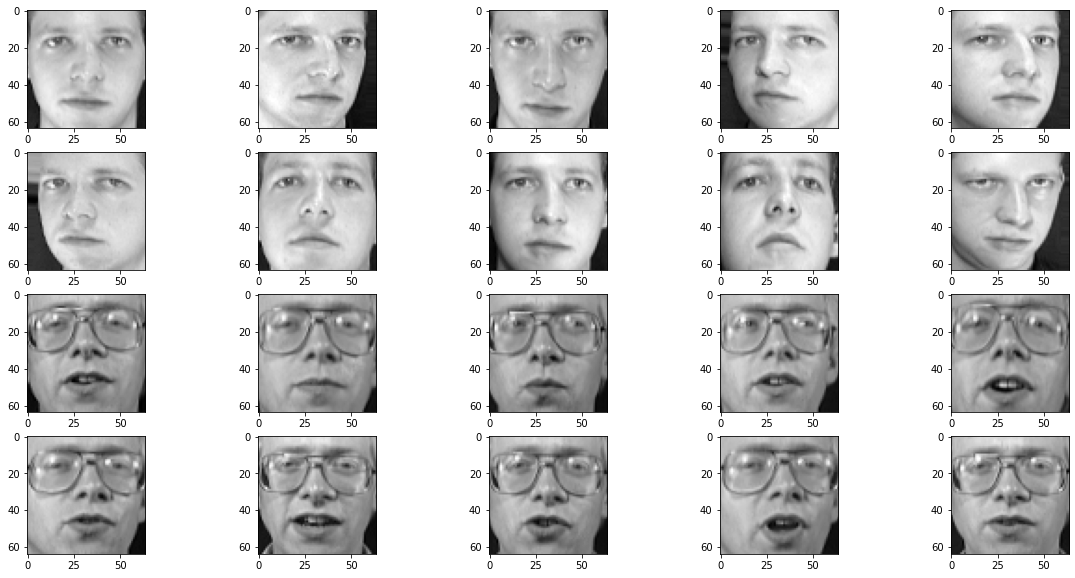

In [94]:
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i in range(0, 20):
    axs[i//5, i%5].imshow(imgs[i], cmap="gray")

## PCA 

In [95]:
pca = PCA().fit(X)

Text(0, 0.5, 'cumulative explained variance')

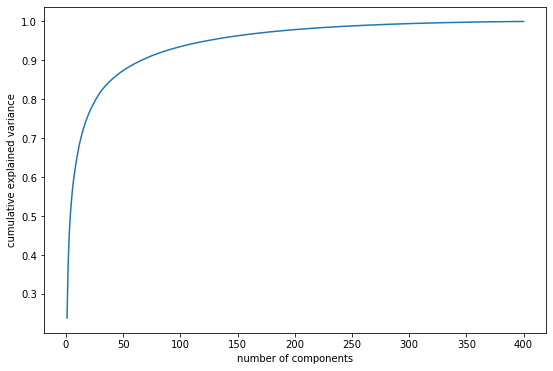

In [96]:
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [97]:
np.argmax(np.cumsum(pca.explained_variance_ratio_)>0.85)

39

Czyli do wyjaśnienia wariancji na poziomie > 85% potrzebujemy jedynie 39 komponentów - tyle właśnie wybierzemy do dalszej pracy. Moglibyśmy wybrać więcej, ale w taki sposób otrzymamy ciekawsze wyniki

In [98]:
pca39=PCA(n_components=39)
X_comp=pca39.fit_transform(X)

### Kompresja

In [99]:
len(X_comp[0])/len(X[0])

0.009521484375

Jak widać, można uzyskać bardzo duży stopień kompresji danych zachowując jednocześnie >85% wariancji. 

## Inverse transformation

In [100]:
def x_comp_to_images(x_comp, pca):
    imgs_comp= pca.inverse_transform(x_comp)
    ret=[]
    for i in range(len(imgs_comp)):
        ret.append(np.reshape(imgs_comp[i], (64,64)))
    return ret

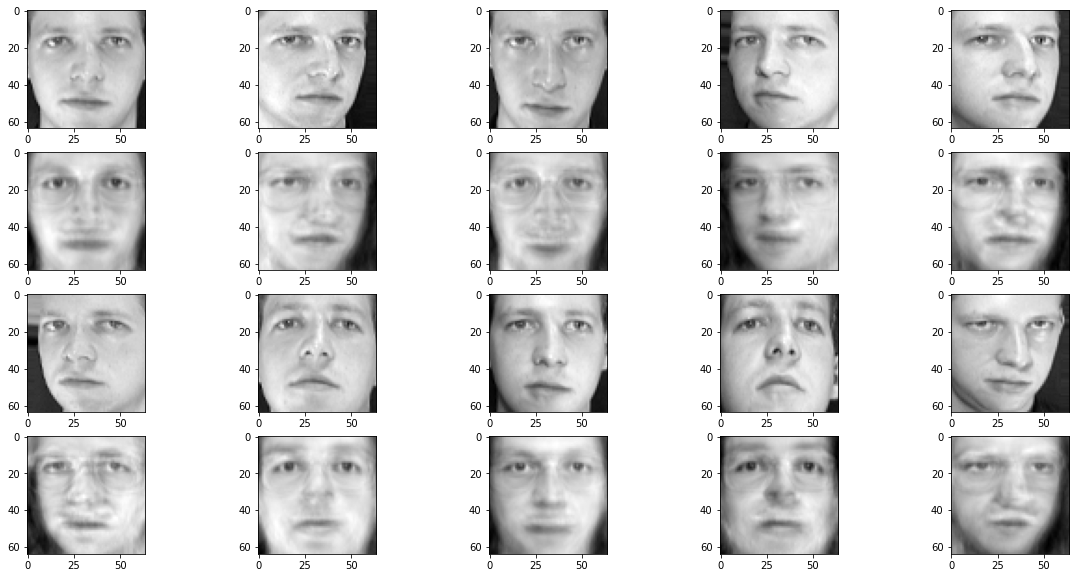

In [101]:
imgs_comp=x_comp_to_images(X_comp, pca39)
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
for i in range(0, 10):
    axs[2*(i//5), i%5].imshow(imgs[i], cmap="gray")
    axs[2*(i//5)+1, i%5].imshow(imgs_comp[i], cmap="gray")
    
    

## RMSE

In [102]:
def listRMSE(x, x_comp):
    lst=[]
    for i in range(len(x)):
        lst.append(mean_squared_error(x[i], x_comp[i]))
    return lst

<AxesSubplot:>

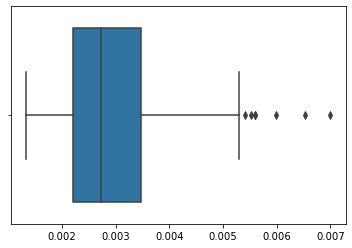

In [103]:
X_comp=pca39.fit_transform(X)

X_comp=pca39.inverse_transform(X_comp)
err=listRMSE(X_og, X_comp)
sns.boxplot(x=err)

Jak widzimy, RMSE jest stosunkowo mały i nie odbiega bardzo znacznie dla żadnych obrazków.

## Modyfikacje

### Negatyw

In [104]:
def negative(x):
    xx=x.copy()
    for i in range(len(xx)):
        for h in range(len(xx[0])):
            xx[i][h]=1-xx[i][h]
    imgs=[]
    for i in range(len(x)):
        imgs.append(np.reshape(xx[i], (64,64)))
    return imgs , xx

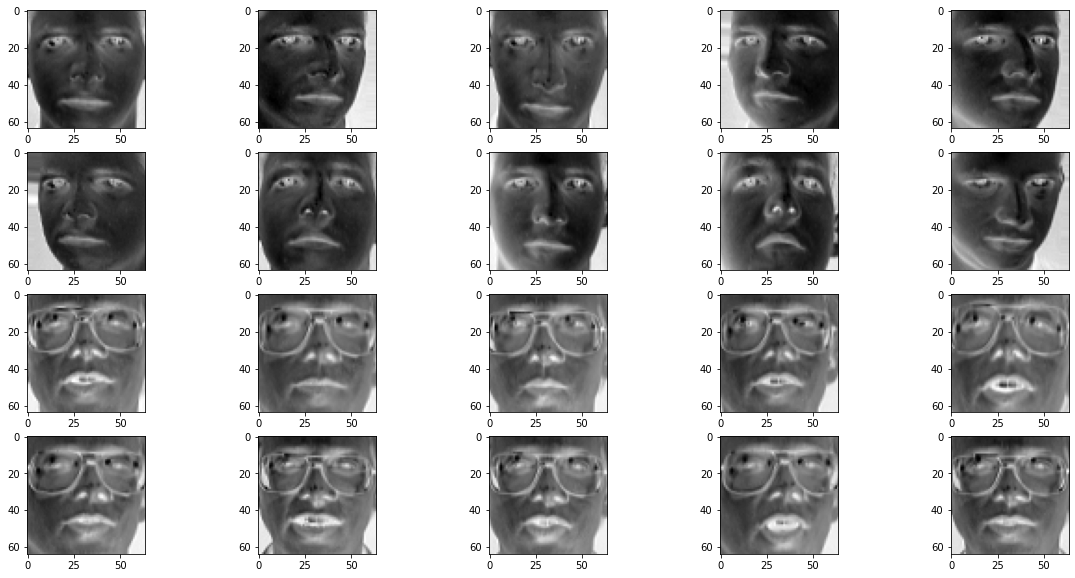

In [105]:
X=ol.data.copy()
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
imgs_neg=negative(X)[0]
for i in range(0, 20):
    axs[i//5, i%5].imshow(imgs_neg[i], cmap="gray")


<AxesSubplot:>

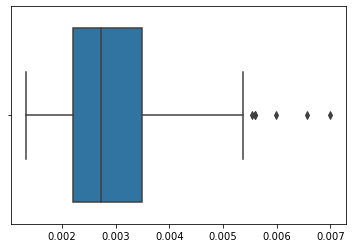

In [106]:
Xt=negative(X)[1]
X_comp=pca39.fit_transform(Xt)
X_comp=pca39.inverse_transform(X_comp)
err=listRMSE(Xt, (X_comp))
sns.boxplot(x=err)

Jak widzimy, wartości błędów są takie same jak dla nieprzekształconych obrazów.

## bw

In [107]:
def bw(x):
    xx=x.copy()
    for i in range(len(xx)):
        for h in range(len(xx[0])):
            if xx[i][h]<0.5:
                xx[i][h]=0
            if xx[i][h]>=0.5:
                xx[i][h]=1
    imgs=[]
    for i in range(len(xx)):
        imgs.append(np.reshape(xx[i], (64,64)))
    return imgs , xx

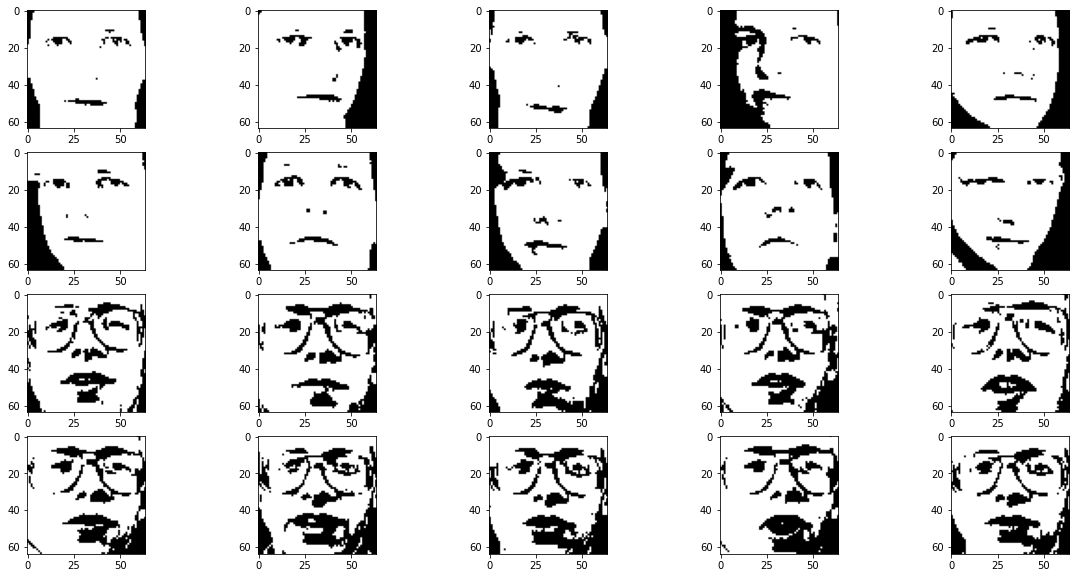

In [108]:
X=ol.data.copy()
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
imgs_neg=bw(X)[0]
for i in range(0, 20):
    axs[i//5, i%5].imshow(imgs_neg[i], cmap="gray")

<AxesSubplot:>

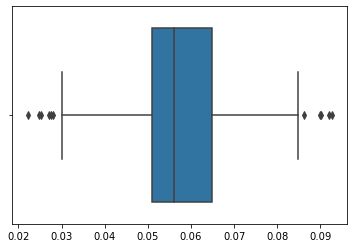

In [109]:
Xbw=bw(X)[1]
X_comp=pca39.fit_transform(Xbw)
X_comp=pca39.inverse_transform(X_comp)
err=listRMSE(Xbw, (X_comp))
sns.boxplot(x=err)

Widzimy, że wartości błędów są tu większe, co jest całkiem ciekawe - może wynika to z tego, że ew. pomyłka jest bardziej kosztowna.

## Anomalie

PCA może służyć do wykrywania pewnych anomalii twarzy - zwróćmy uwagę na obrazy otrzymane w punkcie Inverse Transformation. Widzimy tam, że na zdjęciach mężczyzny pojawia się zaryz okularów, mimo że on sam ich nie miał na oryginalnym zdjęciu - miały je inne zdjęcia w zbiorze danych. Dzięki temu możemy zaobserwować niektóre anomalie na zdjęciach twarzy, jak np okulary czy znaczne znamiona.